In [4]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## We base our first iteration on Unicycle Kinematics.
## https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html
## x = [x,y,x_dot,y_dot,heading]^T
## u = [wheel_speed, heading_rate (rad/s), x_ddot, y_ddot]^T


## Some constants
r = 0.1 # wheel radius

## Define our model
# x_dot = A*x + B*u
#A = 1*np.identity(5)
A = np.array([[0,  0,   0, 0, 0], 
              [0,  0,   0, 0, 0],
              [0,  0,   0, 0, 0],
              [0,  0,   0, 0, 0],
              [0,  0,   0, 0, 0]])
def B(r,x):
    B = np.array([[r*np.cos(x[4]), 0, 0, 0],
                  [r*np.sin(x[4]), 0, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 1, 0, 0]])
    return B

In [12]:
## Tuning parameters
v_k = 0.01*np.array([1.0,1.0,1.0,1.0,1.0]) # process noise

w_k = 0*np.array([1.0,1.0,1.0,1.0,1.0]) # sensor noise

Q_k = 1*np.array([[1.0,  0,   0, 0, 0], # model noise covariance matrix
               [0,  1.0,   0, 0, 0],
               [0,  0,   1.0, 0, 0],
               [0,  0,   0, 1.0, 0],
               [0,  0,   0, 0, 1.0]])

H_k = np.array([[1.0,  0,   0, 0, 0], # observation matrix (also known as G_k, M_k)
               [0,  1.0,   0, 0, 0],
               [0,  0,   1.0, 0, 0],
               [0,  0,   0, 1.0, 0],
               [0,  0,   0, 0, 1.0]])

R_k = 0.001*np.array([[1.0,  0,   0, 0, 0], # observation/estimate noise covariance matrix
               [0,  1.0,   0, 0, 0],
               [0,  0,   1.0, 0, 0],
               [0,  0,   0, 1.0, 0],
               [0,  0,   0, 0, 1.0]])


In [13]:
## IEKF function
def IEKF(z_k, x_k_min_1, u_k_min_1, P_k_min_1,iterative,measurement,T):
    
    # z_k: observation vector
    # x_k_min_1: previous state estimate
    # u_k_min_1: previous input
    # P_k_min_1: previous covariance matrix
    
    # Prediction phase
    
    # Discretize system
    A_disc = (np.identity(5) + A*T)
    B_disc = T*B(r,x_k_min_1)
    #print(u_k_min_1)
    x_k = A_disc @ x_k_min_1 + B_disc @ (u_k_min_1) + w_k # predicted state estimate (x_frown)
    P_k = A_disc @ P_k_min_1 @ A_disc.T + Q_k # updated covariance matrix (pre-correction)
    
    # Skip correction phase if no measurements.
    if(not measurement):
        return x_k,P_k
    
    # Correction phase (EKF)
    S_k = H_k @ P_k @ H_k.T + R_k
    
    y_k_hat = z_k - (H_k @ x_k + v_k) # measurement estimate
    
    K_k = P_k @ H_k.T @ inv(S_k) # near-optimal Kalman gain
    
    x_k_hat = x_k + K_k @ y_k_hat # updated state estimate prediction
    
    P_k = (np.identity(5) - K_k @ H_k) @ P_k # updated covariance matrix (post-correction)
    
    
    # Iterative phase (IEKF)
    if(iterative):
        x_op_k = x_k

        for i in range(10):
            x_k_hat = x_k + K_k @ (z_k - (H_k @ x_op_k + v_k) - H_k @ (x_k - x_op_k)) # updated state estimate prediction
            x_op_k = x_k_hat
    
    # Returning state estimate and covariance
    return x_k_hat, P_k

In [16]:
def simulate_robot():   
    x_k_min_1 = np.array([0.0,0.0,0.0,0.0,0.0]) # initial state
    u_k_min_1 = np.array([5,0.1,0.0,0.0]) # initial input
    P_k_min_1 = 0*np.array([[1.0,  0,   0, 0, 0], # initial covariance
                           [0,  1.0,   0, 0, 0],
                           [0,  0,   1.0, 0, 0],
                           [0,  0,   0, 1.0, 0],
                           [0,  0,   0, 0, 1.0]])
    
    x_hat = []
    y_hat = []
    yaw_hat = []
    
    should_iterate = True
    
    
    
    #Initial input values
    wheelspeed = 5
    headingrate = 0.1
    x_ddot = 0.0
    y_ddot = 0.0
    
    #Initial values for simulation
    h = 0.01
    heading_initial = 0
    x_sim = np.array([0,0,r*np.cos(heading_initial)*wheelspeed,r*np.sin(heading_initial)*wheelspeed,heading_initial]).T #initial simulated states
    x_sim_prev = x_sim

    
    #Bookkeeping lists for plotting
    x_sim_run = []
    x_sim_x = []
    x_sim_y = []
    x_sim_x_dot = []
    x_sim_y_dot = []
    x_sim_yaw = []
    
    # Time array with step
    t = np.arange(0,25,h) # interval between 0 and 25 with stepsize of 0.01 => 2500 steps.
    
    for k in range(t.size):
        
        # Measurement logic
        measurement = False
        
        # Artificial sensor noise
        noise_x = np.random.normal(0,v_k[0],1)[0]
        noise_y = np.random.normal(0,v_k[1],1)[0]
        noise_x_ddot = np.random.normal(0,v_k[2],1)[0]
        noise_y_ddot = np.random.normal(0,v_k[3],1)[0]
        noise_yaw = np.random.normal(0,v_k[4],1)[0]
        
        
    
        # Generate states from our original model (x,y,heading)
        u_sim = np.array([wheelspeed, headingrate, x_ddot, y_ddot]).T
        A_d = (np.identity(5) + A*h)
        B_d = h*B(r,x_k_min_1)
        #x_sim_dot = A_d@x_sim + B_d@u_sim
        x_sim_dot = A@x_sim + B(r,x_sim)@u_sim
        x_sim = x_sim + x_sim_dot*h
        x_sim_x.append(x_sim[0])
        x_sim_y.append(x_sim[1])
        x_sim_x_dot.append(x_sim_dot[0])
        x_sim_y_dot.append(x_sim_dot[1])
        x_sim_yaw.append(x_sim[4])
        
        x_ddot = x_sim_dot[2]
        y_ddot = x_sim_dot[3]
        
        
         
        # Only use direct position measurements at a frequency of 1/100, otherwise use acceleration integrated up.
        if(k%100 == 0):    
            z_k_obs = [x_sim[0]+noise_x,x_sim[1]+noise_y,0,0,0]
            
            
            H_k = np.array([[1.0,  0,   0, 0, 0], # Update observation matrix to account for position measurements
                           [0,  1.0,   0, 0, 0],
                           [0,  0,   0, 0, 0],
                           [0,  0,   0, 0, 0],
                           [0,  0,   0, 0, 0]])
            
        else:
            
            #measurement = False
            
            
            H_k = np.array([[0,  0,   0, 0, 0], # Update observation matrix to zero matrix, as acceleration measurements are given as inputs
                           [0,  0,   0, 0, 0],
                           [0,  0,   0, 0, 0],
                           [0,  0,   0, 0, 0],
                           [0,  0,   0, 0, 1]])
            B_u = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 1, 0, 0]])
            u_measur = np.array([0, headingrate, x_ddot, y_ddot]).T
            z_k_obs = H_k@x_sim + B_u@u_measur
        
        # Update estimate and covariance
        x_k_hat, P_k = IEKF(z_k_obs, x_k_min_1,u_sim,P_k_min_1,should_iterate,measurement,h)
         
        # Get ready for the next timestep by updating the variable values
        x_k_min_1 = x_k_hat
        P_k_min_1 = P_k
        
        # Add values to lists for plotting
        x_hat.append(x_k_hat[0])
        y_hat.append(x_k_hat[1])
        yaw_hat.append(x_k_hat[4])
    
    # Plot trajectory and yaw estimates vs simulated
    
    plt.plot(x_sim_x, x_sim_y, label="x and y sim")
    plt.plot(x_hat,y_hat, label="trajectory_hat")
    plt.legend()
    plt.show()
    
    
    plt.plot(t, yaw_hat, label="yaw_hat")
    plt.plot(t, x_sim_yaw, label="yaw_sim")
    
    plt.legend()
    plt.show()
    
    #plt.plot(x_sim_x_dot, x_sim_y_dot, label="x_dot and y_dot sim")
    plt.plot(t, x_sim_y_dot, label="x_sim_y_dot")
    plt.plot(t, x_sim_x_dot, label="x_sim_x_dot")
    
    
    plt.legend()
    plt.show()
    

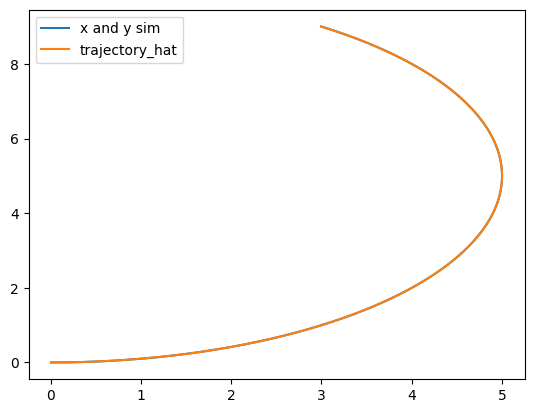

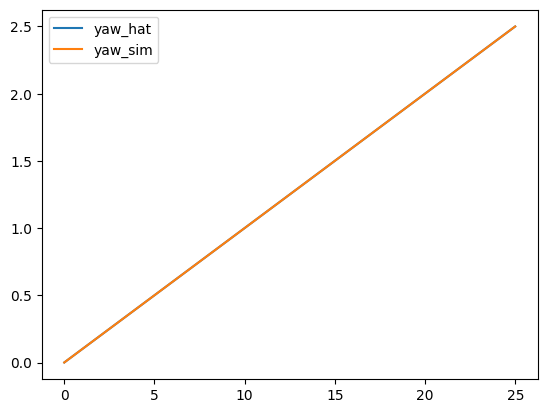

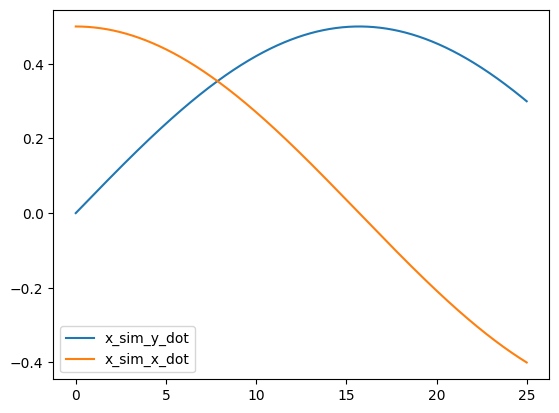

In [17]:
simulate_robot()